## IRF for different $(X_{t-1}, R_{t-1}^a)$ states under the speculative channel

The impulse response function (IRF) for price is defined as

$$
\mathbb E \left( P_{t+k} \mid R_t^a = \mu_R (1-\rho_R) + \rho_R R_{t-1}^a + \sigma_R \sqrt{1-\rho_R^2}, X_{t-1}, R_{t-1}^a \right)
    - \mathbb E \left(P_{t+k} \mid X_{t-1}, R_{t-1}^a \right),
\quad k = 0,1, \dots, K.
$$

We consider impulse responses in percentages when necessary. 
  
Since $\{R_t^a\}$ is a finite Markov chain, to represent the same shock to $\varepsilon_t^R$ for different $R_{t-1}^a$, we find the minimum state point of $\{R_t^a\}$ that is greater than or equal to $\mu_R (1-\rho_R) + \rho_R R_{t-1}^a + \sigma_R \sqrt{1-\rho_R^2}$. 

As long as the Tauchen discretizaion is sufficiently fine (e.g., a 500-state discretization), the resulting error should be minor. 

In [1]:
run pricing

In [2]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["figure.autolayout"] = True

### Some global parameters

In [3]:
# Gaussian quadrature sample points and weights
gq_points, gq_weights = gauss_quadra()

# State points and prob trans matrix of {R_t}
μ_R = 1.006230606825128     # stationary mean of {R_t}
ρ_R = 0.9407262699728842    # autocor. coef. of {R_t}
σ_R = 0.030020587135876593  # stationary std dev of {R_t}
μ_R_adj = μ_R*(1-ρ_R)            # the intercept of the AR(1) process  
σ_R_adj = σ_R*np.sqrt(1-ρ_R**2)  # the std dev of the AR(1) innovation
Ra_vals, Π = build_dynamics(μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj, size=101)

# Size of MC samples & forwarding steps for IRF
size, periods = 100_000, 17 

# A class that stores model information
cp = CommodityPricing(δ=0.02,
                      λ=0.1,
                      κ=0.0,
                      σ_Y=0.05,
                      Ra_vals=Ra_vals, Π=Π,
                      grid_size=100,
                      gq_points=gq_points,
                      gq_weights=gq_weights)
test_stability(cp, verbose=True)

# Size of MC samples & discarded samples to compute stat dist
L, burn_in = 200_000, 50_000

# Simulate {R_t} indices process
mc = MarkovChain(cp.Π)
Ra_seq = mc.simulate(L+1, random_state=1234)

# Simulate {Y_t} process
Y_sim = truncnorm.rvs(a=-cp.trunc_Y,
                      b=cp.trunc_Y,
                      size=L+1,
                      loc=cp.μ_Y,
                      scale=cp.μ_Y * cp.σ_Y,
                      random_state=5678)

X0_percs = [0.25, None, 0.75, 0.95]


TRUNCATED_NORMAL_RULE
  Python version: 3.10.14

  For the (truncated) Gaussian probability density function
    pdf(x) = exp(-0.5*((x-MU)/SIGMA)^2) / SIGMA / sqrt ( 2 * pi )
  compute an N-point quadrature rule for approximating
    Integral ( A <= x <= B ) f(x) pdf(x) dx

  The value of OPTION determines the truncation interval [A,B]:
  0: (-oo,+oo)
  1: [A,+oo)
  2: (-oo,B]
  3: [A,B]

  The user specifies OPTION, N, MU, SIGMA, A, B and FILENAME.

  HEADER is used to generate 3 files:

    header_w.txt - the weight file
    header_x.txt - the abscissa file.
    header_r.txt - the region file, listing A and B.

  OPTION = 3
  N = 7
  MU = 0
  SIGMA = 1
  A = -5
  B = 5
  HEADER = "gauss_quad"

  Creating quadrature files.

  Common header is      "gauss_quad".

  Weight file will be   "gauss_quad_w.txt".
  Abscissa file will be "gauss_quad_x.txt".
  Region file will be   "gauss_quad_r.txt".

TRUNCATED_NORMAL_RULE:
  Normal end of execution.

Stability condition holds: G < exp(δ).

G

### IRF vs $X_{t-1}$ and $R_{t-1}^a$ (multi-periods)

In [4]:
def irf_XR_H(δ, λ, X0_percs, Ra0s, shocks, periods=17):
    """
    IRF for different (δ, λ, X0_percs, Ra0s, shocks, periods) values.
    Multiple (X0_perc, Ra0).
    """
    irf_P, irf_I, irf_ES = [np.empty((periods,
                                      len(X0_percs), 
                                      len(Ra0s))) for i in range(3)]
    for i, X0_perc in enumerate(X0_percs):
        for j, Ra0 in enumerate(Ra0s):
            impul_P, impul_I, _, _, impul_ES, _ = irf_vs_params(δ, λ, L, burn_in, 
                                                                shocks[j], Ra0, X0_perc,
                                                                Ra_vals, Π, Ra_seq, Y_sim, 
                                                                gq_points, gq_weights,
                                                                size=size, periods=periods)
            irf_P[:,i,j], irf_I[:,i,j], irf_ES[:,i,j] = impul_P, impul_I, impul_ES
    return irf_P, irf_I, irf_ES

In [5]:
δ, λ = 0.02, 0.06

#### Case 1. IRF vs $X_{t-1}$ 

Fix $R_{t-1}^a$ at the stationary mean.

In [6]:
Ra0_perc = 50

# A 100-BP positive interest rate shock
shock = find_next_Ra(cp, Ra0_perc, shock=0.01 / σ_R_adj, 
                     μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj)

In [7]:
irf_PH, irf_IH, irf_PstdH = irf_XR_H(δ, λ, X0_percs, [Ra0_perc], [shock])
irf_PH, irf_IH, irf_PstdH = irf_PH[:,:,0], irf_IH[:,:,0], irf_PstdH[:,:,0]

#### Case 2. IRF vs $R_{t-1}^a$ 
Fix $X_{t-1}$ at the stationay mean.

In [8]:
Ra0_percs = np.quantile(Ra_seq[burn_in+1:], [0, 0.05, 0.25, 0.75, 0.95])
Ra0_percs = np.insert(Ra0_percs, 3, 50)  # add the theoretical mean state 
Ra0_percs = np.array(Ra0_percs, dtype=int)

# A 100-BP positive interest rate shock
shocks = [find_next_Ra(cp, Ra0, shock=0.01 / σ_R_adj, 
                       μ_R=μ_R_adj, ρ_R=ρ_R, σ_R=σ_R_adj) for Ra0 in Ra0_percs]

In [9]:
irf_PH2, irf_IH2, irf_PstdH2 = irf_XR_H(δ, λ, [None], Ra0_percs, shocks)
irf_PH2, irf_IH2, irf_PstdH2 = irf_PH2[:,0,:], irf_IH2[:,0,:], irf_PstdH2[:,0,:]

In [10]:
irf_PH[0,:]

array([-0.00814905, -0.01160762, -0.01402766, -0.01769889])

In [11]:
irf_PH[0,2]/irf_PH[0,0]

1.7213859448366207

In [12]:
irf_PH[0,-1]/irf_PH[0,0]

2.1718953407695594

In [13]:
Ra0_percs

array([ 0, 22, 38, 50, 61, 76])

In [14]:
Ra_vals[Ra0_percs]

array([0.91616885, 0.95579602, 0.98461578, 1.00623061, 1.02604419,
       1.05306272])

In [15]:
Ra_vals[Ra0_percs] + 0.01

array([0.92616885, 0.96579602, 0.99461578, 1.01623061, 1.03604419,
       1.06306272])

#### IRF plot

In [17]:
# dat = np.load('../output/simulation_results/irf_state.dat.npz')
# irf_PH = dat['irf_PH'] 
# irf_IH = dat['irf_IH']
# irf_PstdH = dat['irf_PstdH']
# irf_PH2 = dat['irf_PH2'] 
# irf_IH2 = dat['irf_IH2'] 
# irf_PstdH2 = dat['irf_PstdH2']

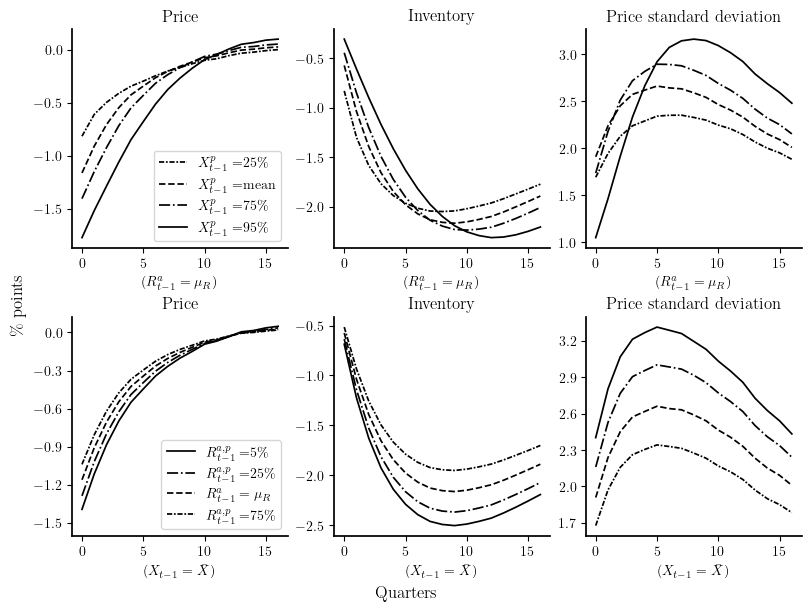

In [18]:
fig, axes = plt.subplots(2,3, figsize=(8,6), layout='constrained', 
                         gridspec_kw={'width_ratios': [5,5,5]})
fig.set_constrained_layout_pads(w_pad=3./72., h_pad=3./72.)
irf_set1 = [irf_PH, irf_IH, irf_PstdH]
irf_set2 = [irf_PH2[:,1:-1], irf_IH2[:,1:-1], irf_PstdH2[:,1:-1]]
irf_sets = [irf_set1, irf_set2]
labs_X = ['25\%', 'mean', '75\%', '95\%']
labs_R = ['5\%', '25\%', 'mean', '75\%']
lss = [(0,(3,1,1,1)), '--', '-.', '-']
titles = ['Price', 'Inventory', 'Price standard deviation']
lw = 1.25

for k in range(len(irf_sets)):
    for j in range(len(irf_set1)):
        ax = axes[k,j]
        ax.spines['left'].set_linewidth(1.25)
        ax.spines['bottom'].set_linewidth(1.25)
        ax.set_title(titles[j], fontweight='bold')
        ax.set_xticks([0,5,10,15])
        if k == 0:
            ax.set_xlabel('($R_{t-1}^a = \mu_R$)')
            for i, X0_perc in enumerate(X0_percs):
                ax.plot(irf_sets[k][j][:,i]*100, ls=lss[i], c='black', lw=lw,
                        label=f'$X_{{t-1}}^p=${labs_X[i]}')
            if j == 0:
                ax.legend()
        else:
            ax.set_xlabel('($X_{t-1} = \\bar X$)')
            for i, Ra0_perc in enumerate(Ra0_percs[1:-1]):
                if i != 2:
                    ax.plot(irf_sets[k][j][:,i]*100, ls=lss[-(i+1)], c='black', lw=lw,
                            label=f'$R_{{t-1}}^{{a,p}}=${labs_R[i]}')
                    if j==0 and i==0:
                        ax.set_ylim(-1.6,)
                        ax.set_yticks(np.linspace(-1.5, 0, 6))
                    if j==2:
                        ax.set_yticks(np.linspace(1.7, 3.2, 6))
                        
                else:
                    ax.plot(irf_sets[k][j][:,i]*100, ls=lss[-(i+1)], c='black', lw=lw,
                            label=f'$R_{{t-1}}^a=\mu_R$')      
            if j==0:
                ax.legend()
fig.supxlabel('Quarters')
fig.supylabel('$\%$ points')
plt.savefig('../output/figures/irf_state_Xpast_base.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [19]:
# np.savez('../output/simulation_results/irf_state.dat',
#          irf_PH=irf_PH, irf_IH=irf_IH, irf_PstdH=irf_PstdH,
#          irf_PH2=irf_PH2, irf_IH2=irf_IH2, irf_PstdH2=irf_PstdH2)